In [21]:
# from deap import base, creator, tools, algorithms
from dedalus import public as de
from dedalus.extras.plot_tools import plot_bot_2d
from dedalus.extras import *
import numpy as np
import scipy
from scipy import integrate, interpolate
import pickle
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd


import time as timeski
import os

#Suppress most Dedalus output
de.logging_setup.rootlogger.setLevel('ERROR')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
# rcParams['font.sans-serif'] = ['Tahoma']
rcParams.update({'font.size': 12})

In [22]:
###################################################################
# Simulation Functions
###################################################################

#Scale list between 0 and 1
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

# steady state ODE
def ssODE(y,t,params):
    u,v,g,G = y
    b,gamma,n,sigma,e,c,d= params
    K = 1
    
    du = b*v+v*gamma*u**n/(K**n+u**n)-sigma*u-e*G*u
    dv = -du

    dG = c*u*g-d*G
    dg = - dG
    
    derivs = [du,dv,dg,dG]
    return derivs

#determine homogenous SS using ssODE
def homogenousSS(u,v,g,G,params):

    y0 = (u,v,g,G)
    t_sim = (0,1000)
    odeSoln = integrate.odeint(ssODE,y0,t_sim,args=(params,),mxstep=1000000) 
      
    return(odeSoln[1])

def exp_decay_gradient(p_ss,p_p,p_m,rs,mu_F):
    p_max = np.max([p_ss,p_p])
    p_min = np.min([p_ss,p_p])
    
    increased = False
    if p_max == p_p: 
        increased = True
        ps = [p_max if r < mu_F else p_min+(p_max-p_min)*np.exp(-p_m*(r-mu_F)) for r in rs]
    
    else: ps = (p_max+p_min)*np.ones(len(rs))-[p_max if r < mu_F else p_min+(p_max-p_min)*np.exp(-p_m*(r-mu_F)) for r in rs ]
    
    return(ps)

def WPGAP_2D(params):
    [b,c,sigma,e,gamma,d] = params

    x_basis=de.Fourier('x',64,interval=(0,4),dealias=3/2)
    y_basis=de.Chebyshev('y',64,interval=(0,4),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([x_basis,y_basis],float)

    x,y = domain.grids(scales=1)


    T = 4.04 
    Tg = 10
    n = 2

    Du = .004
    Dv = 100*Du
    DG = 100*Du #40*Du
    Dg = 100*Du

    p_ss = [b,gamma,n,sigma,e,c,d]
    u0,v0,g0,G0 = homogenousSS(T/2,T/2, Tg/2, Tg/2,p_ss)

    # Specify problem
    problem = de.IVP(domain, variables=['u', 'v','uy','vy','G','g','Gy','gy'])
#     problem = de.IVP(domain, variables=['u', 'v','ur','vr','G','g','Gr','gr'])

    problem.parameters['u0'] = u0
    problem.parameters['v0'] = v0
    problem.parameters['G0'] = G0
    problem.parameters['g0'] = g0
    problem.parameters['Tg'] = Tg
    
    problem.parameters['gamma'] = gamma
    problem.parameters['b'] = b
    problem.parameters['n'] = n
    problem.parameters['c'] = c
    problem.parameters['dd'] = d
    problem.parameters['sigma'] = sigma
    problem.parameters['e'] = e

    problem.parameters['Du'] = Du
    problem.parameters['Dv'] = Dv

    problem.parameters['DG'] = DG
    problem.parameters['Dg'] = Dg
    
    

    problem.substitutions['f(u,v,G)'] = 'b*v+v*gamma*u**n/(1+u**n)-sigma*u-e*G*u'
    problem.substitutions['fg(u,G,g)'] = 'c*u*g-dd*G'
        
    
    # Mass always conserved
    problem.substitutions['minf(u,v,G)'] = '-f(u,v,G)'
    problem.substitutions['minfg(u,G,g)'] = '-fg(u,G,g)'
    

    problem.add_equation("dt(u)-Du*dx(dx(u))-Du*dy(uy)=f(u,v,G)")
    problem.add_equation("dt(v)-Dv*dx(dx(v))-Dv*dy(vy)=minf(u,v,G)")
    problem.add_equation("dt(G)-DG*dx(dx(G))-DG*dy(Gy)=fg(u,G,g)")
    problem.add_equation("dt(g)-Dg*dx(dx(g))-Dg*dy(gy)=minfg(u,G,g)")

    problem.add_equation("uy-dy(u)=0")
    problem.add_equation("vy-dy(v)=0")

    problem.add_equation("Gy-dy(G)=0")
    problem.add_equation("gy-dy(g)=0")

    # # Neumann boundary conditions

    problem.add_bc("left (uy) = 0")
    problem.add_bc("right (uy) = 0")
    problem.add_bc("left (vy) = 0")
    problem.add_bc("right (vy) = 0")
    problem.add_bc("left (Gy) = 0")
    problem.add_bc("right (Gy) = 0")
    problem.add_bc("left (gy) = 0")
    problem.add_bc("right (gy) = 0")



    # Pick a timestepper
    ts = de.timesteppers.RK443 #RK222
    # Build solver
    solver = problem.build_solver(ts)
    # Set integration limits
    solver.stop_wall_time = np.inf
    solver.stop_sim_time = np.inf
    solver.stop_iteration = np.inf
    # Set initial conditions
    u = solver.state ['u']
    v = solver.state['v']
    G = solver.state ['G']
    g = solver.state['g']
    
    urand = 0.01*v0*np.random.rand(*u['g'].shape)
    u['g'] = u0+urand
    v['g'] = v0-urand
    G['g'] = G0*np.ones(G['g'].shape)
    g['g'] = g0*np.ones(g['g'].shape)

    solver.stop_iteration = 2000
    
    dt =  0.25 #0.1
    nonan = True
    not_steady = True
    prev_state = np.zeros((64*3//2,64*3//2)) 
    # Main loop chceking stopping criteria
    while solver.ok and nonan and not_steady:
        # Step forward
        solver.step(dt)

        if solver.iteration % 50 == 0:
            if np.count_nonzero(np.isnan(u['g'])) > 0 or np.min(u['g']) < 0 :
                return('Numerical Error')
                nonan = False  
               
        if solver.iteration% 50 ==0:
            curr_state = np.array(u['g'])
            if np.max(np.abs(curr_state-prev_state)) < 10e-4:
#                 print(np.max(np.abs(curr_state-prev_state)))
#                 print('Steady state at t = %.2f'%(np.round(solver.iteration*dt,2)))
                not_steady = False
            else: prev_state = np.array(u['g'])

    return u['g'].T


In [23]:
# fixed values/mean values after MCMC parameterization

b = 0.0002
sigma = 0.04
e = 3.1396782799850596
d = 4.298093795969064

/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


KeyboardInterrupt: 

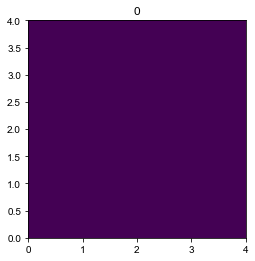

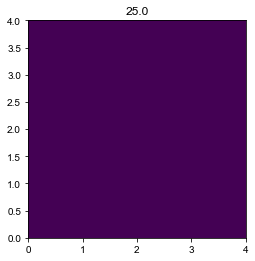

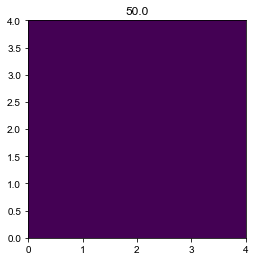

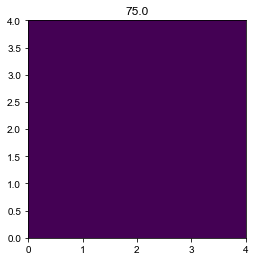

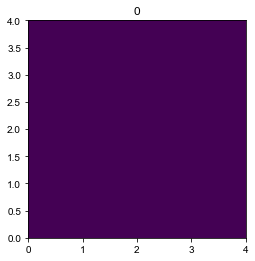

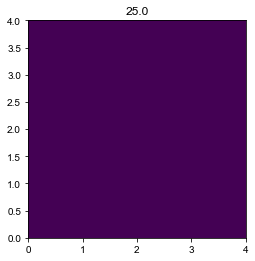

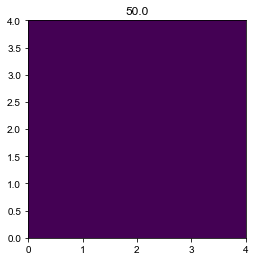

In [6]:
us_cgam = []

for c_val in np.linspace(0.05,0.3,11):
    for gam_val in np.linspace(0.1,0.6,11):
        ps = [b,c_val,sigma,e,gam_val,d]
        u = WPGAP_2D(ps)
        us_cgam.append(u)

In [1]:
# define original grid used by Dedalus, will interpolate (same # grid points) to plot on an evenly spaced grid

x_basis=de.Fourier('x',64,interval=(0,4),dealias=3/2)
y_basis=de.Chebyshev('y',64,interval=(0,4),dealias=3/2)
#Domain:bases,datatype
domain=de.Domain([x_basis,y_basis],float)
x,y = domain.grids(scales=domain.dealias)
X,Y = np.meshgrid(x,y)
grid_x, grid_y = np.mgrid[0:4:64j, 0:4:64j]
original_grid = np.vstack([X.flatten(),Y.flatten()]).T


NameError: name 'de' is not defined

In [136]:
#create a list of our simulations with evenly spaced grid points

us_cgam_eqs = []
for u in us_cgam:
    grid_z0 = interpolate.griddata(original_grid, u.flatten(), (grid_x, grid_y), method='nearest')
    us_cgam_eqs.append(grid_z0)

In [137]:
#create an organized grid of our simulations

us_cgam_grid = []

for i in np.arange(0,11*11,11):
    us_cgam_grid.append(np.vstack(us_cgam_eqs[i:i+11]))

us_cgam_grid = np.hstack(us_cgam_grid)

In [ ]:
#import non-constant c and gamma values post MCMC
all_cs = pickle.load(open('mean_c_vals.pickle','rb'))
all_gams = pickle.load(open('mean_gamma_vals.pickle','rb'))

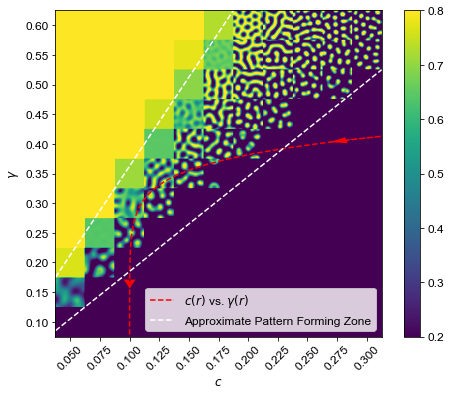

In [470]:
#plot grid with c verus gamma from MCMC in this region


plt.figure(figsize=(8,6))

xlabels = np.around(np.linspace(0.05,0.30,11),3)
dx = (xlabels[1]-xlabels[0])/2
xticks=np.linspace(0.05-dx,0.3+dx,13)[1:-1]

ylabels = np.around(np.linspace(0.1,0.6,11),3)
dy = (ylabels[1]-ylabels[0])/2
yticks = np.linspace(0.1-dy,0.6+dy,13)[1:-1]

plt.imshow(us_cgam_grid,origin='lower',extent=[0.05-dx,0.3+dx,0.1-dy,0.6+dy],aspect = 1/2,vmin= 0.2, vmax = 0.8)
plt.colorbar()

plt.ylabel(r'$\gamma$')
plt.xlabel(r'$c$')
plt.ylim([0.1-dy,0.6+dy])
plt.xlim([0.05-dx,0.3+dx])

plt.plot(all_cs,all_gams,"--",c='r')

plt.plot(100,100,"--",color='white')

plt.plot([0.05-dx,0.3+dx],[0.11-dy,0.5+dy],"--",c='white')
plt.plot([0.05-dx,0.175+dx],[0.2-dy,0.6+dy],"--",c='white')

plt.legend(['$c(r)$ vs. $\gamma(r)$','Approximate Pattern Forming Zone'],loc='lower right')

plt.arrow(all_cs[94],all_gams[94],all_cs[95]-all_cs[94],all_gams[95]-all_gams[94],
          color='r',shape='full', lw=0, length_includes_head=True, head_width=.01)
plt.arrow(all_cs[126],all_gams[126],all_cs[127]-all_cs[126],all_gams[127]-all_gams[126],
          color='r',shape='full', lw=0, length_includes_head=True, head_width=.01)



plt.xticks(xlabels,rotation=45)
plt.yticks(ylabels)

# plt.savefig('Figures/Parameter_Sweep_C_vs_Gam_Final.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('Figures/Parameter_Sweep_C_vs_Gam_Final.png',dpi=300,bbox_inches='tight')

plt.show()
